In [283]:
import numpy as np
import tensorflow.keras.backend as backend 
import io
import os
import urllib
import zipfile
import time 
import boto3
import boto.s3
import sys
import json
from orion import Orion
import logging
import pickle
from typing import List, Union
import pandas as pd
from mlblocks import MLPipeline
from orion.evaluation import CONTEXTUAL_METRICS as METRICS
from orion.evaluation import contextual_confusion_matrix
from functools import partial
from orion.data import load_signal, load_anomalies
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
S3_URL = 'https://d3-ai-orion-analysis.s3.amazonaws.com/'
BUCKET = "d3-ai-orion-analysis"


In [212]:
signal_name = 'S-1'
# load signal
train_data = load_signal(signal_name)
# load ground truth anomalies
# known_anomalies = load_anomalies(signal)

df = pd.DataFrame(train_data["value"])


In [213]:
def build_df(data, start=0):
    index = np.array(range(start, start + len(data)))
    step = 300
    initial_time = 1222819200 
    timestamp = index * step + initial_time 
    return pd.DataFrame({'timestamp': timestamp}, dtype='int64')
def time_index(index):
    step = 300
    initial_time = 1222819200
    return index * step + initial_time

In [214]:
def get_creds():    
    credentials_file = "credentials_file.txt" #some path
    with open(credentials_file) as file:
        lines = file.readlines()
        ACCESS_KEY_ID_LINE_NUM = 2
        SECRET_ACCESS_KEY_ID_LINE_NUM = 3
        access_key_id = lines[ACCESS_KEY_ID_LINE_NUM]
        secret_access_key = lines[SECRET_ACCESS_KEY_ID_LINE_NUM]
        
        access_key_id = access_key_id.replace("\n", "")
        secret_access_key = secret_access_key.replace("\n", "")
    return access_key_id, secret_access_key    
    
def send_file_to_s3(file_path, file_name): 
    # Creating Session With Boto3.
    # Creating S3 Resource From the Session.
    # Fetch S3 credentials from credentials file
    print("Sending file {file_name} to S3".format(file_name=file_name))
    access_key_id, secret_access_key = get_creds()
    s3 = boto3.Session(
        aws_access_key_id = access_key_id,
        aws_secret_access_key = secret_access_key
    ).resource('s3')

    result = s3.Bucket(BUCKET).upload_file(file_path, file_name)

    
def load_anomalies_from_s3():
    file_name = 'anomalies.csv'
    # Fetch S3 credentials from credentials file
    access_key_id, secret_access_key = get_creds()
    s3 = boto3.Session(
        aws_access_key_id = access_key_id,
        aws_secret_access_key = secret_access_key
    ).resource('s3')
    
    file = s3.Object(BUCKET, file_name).get()['Body'].read()
    
    return file
    

def load_file_from_s3(s3_file_name):
    
    # Creates local file path to load from
    file_epoch_ending = s3_file_name.split("/")[1]

    PREFIX_AFTER_EPOCH_STR = 8
    INDEX_BEFORE_EXT = -4
    file_type = file_epoch_ending[PREFIX_AFTER_EPOCH_STR:INDEX_BEFORE_EXT]
    
    if file_type == "anomalies" or file_type == "report":
        file_content = pd.read_csv(S3_URL + s3_file_name, index_col=False)
        
    else : 
        # Fetch S3 credentials from credentials file    
        access_key_id, secret_access_key = get_creds()
        s3 = boto3.Session(
            aws_access_key_id = access_key_id,
            aws_secret_access_key = secret_access_key
        ).resource('s3')

        bucket = s3.Bucket(BUCKET)

        with open(s3_file_name[-4] + "-local_copy.pkl", 'wb') as data:
            bucket.download_fileobj(s3_file_name, data)

        with open(s3_file_name[-4] + "-local_copy.pkl", 'rb') as data:
            file_content = pickle.load(data)
    
    return file_content

def delete_file_from_s3(file_name):
    
    access_key_id, secret_access_key = get_creds()
    s3 = boto3.Session(
        aws_access_key_id = access_key_id,
        aws_secret_access_key = secret_access_key
    ).resource('s3')
        
    return s3.Object(BUCKET, file_name).delete() # your-key is the signature of the object you want to delete
    


In [215]:
def get_ground_truth_anomalies(signal_name):
    anomalies = list()
    
    # if signal_name == 'S-1':
    anomalies = load_anomalies_from_s3()

    # Might need to implement other way of retrieving anomalies
    return anomalies


In [216]:

def get_scores(orion, signal_name, original_time_series, gen_time_series, detected_anomalies):
    """
    Extract Confusion Matrix, F1 Scores and MSE from data
    """
    METRICS['confusion_matrix'] =  contextual_confusion_matrix
    
    metrics_overlap = METRICS.copy()
    
    metrics_overlap = {name + '_overlap': partial(fun, weighted=False) for name, fun in metrics_overlap.items()}

    metrics = {**METRICS, **metrics_overlap}
    # dict of {[name of fn] : fn itself}
    
    # scorer input
    # ground truth anomalies (from anomalies.csv in s3bucket)
    # detected anomalies (output of orion/pipeline)
    # data (signal)
    train_data = load_signal(signal_name)
    ground_truth_anomalies = get_ground_truth_anomalies(signal_name)
    data = train_data
    scores = {}
    for name, scorer in metrics.items():
        try:
            scores[name] = [scorer(ground_truth_anomalies, detected_anomalies, data)]
        except Exception as ex:
            scores[name] = 0
    data = pd.DataFrame(train_data["value"])
    
    mse = mean_squared_error(original_time_series, gen_time_series)
    scores["MSE"] = [mse]
    return scores


In [217]:

def get_dataset_name_for_signal(signal_name):
    
    dataset_file_name = "datasets_names.csv "
    datasets_to_signals = dict()
    # This program assumes the csv file has a header. 
    # In case of missing header in the csv file, we have to pass it explicitly to the program
    csv_file = pd.DataFrame(pd.read_csv(dataset_file_name, sep = ",", header = None, index_col = False))
    csv_file.to_json("datasets.json", orient = "records", date_format = "epoch", double_precision = 10, force_ascii = True, date_unit = "ms", default_handler = None)
    
    with open("datasets.json") as f:
        json_list = json.load(f)
        
    
    for json_dict in json_list:
        dataset_name = json_dict['0'] 
        corresponding_signals = json_dict['1']
        
        datasets_to_signals[dataset_name] = corresponding_signals
    
    signals_to_datasets = dict()
    
    for dataset_name in datasets_to_signals.keys():
        formatted_signals_list = datasets_to_signals[dataset_name].replace('\'', '').replace('(', '').replace(')', '').replace(' ', '').split(',')
        for signal in formatted_signals_list:
            
            signals_to_datasets[signal] = dataset_name
    
    return signals_to_datasets[signal_name]
    


In [218]:
def send_anomalies_timeseries_scores(orion, signal_name, current_epoch, pkl_file_substring):
    train_data = load_signal(signal_name)
    anomalies, viz = orion.detect(train_data, visualization=True)
    
    gen_time_series = viz["generated_timeseries"]
    original_time_series = viz["original_timeseries"]
    
    # SAVE F1 Scores and MSEs using VIZ 
    # GET F1 SCORES using get_scores()
    scores = get_scores(orion, signal_name, original_time_series, gen_time_series, anomalies)
    print(scores, "THESE ARE THE SCORES!!")
    scores_df = pd.DataFrame.from_dict(scores)
    print(scores_df, "THESE ARE THE SCORES_DF!!")
    # Creates local file path to load from
#     anomalies_path = os.path.join(os.path.abspath('.'), pkl_file_substring + "epoch_{current_epoch}-anomalies.pkl".format(current_epoch=current_epoch))
#     gen_time_series_path = os.path.join(os.path.abspath('.'), pkl_file_substring + "epoch_{current_epoch}-generated_timeseries.pkl".format(current_epoch=current_epoch))

    anomalies_path = pkl_file_substring + "epoch_{current_epoch}-anomalies.csv".format(current_epoch=current_epoch)
    gen_time_series_path = pkl_file_substring + "epoch_{current_epoch}-generated_timeseries.pkl".format(current_epoch=current_epoch)
    orion_path = pkl_file_substring + "epoch_{current_epoch}-orion.pkl".format(current_epoch=current_epoch)
#     report_path = pkl_file_substring + "epoch_{current_epoch}-report.pkl".format(current_epoch=current_epoch)
    report_path = pkl_file_substring + "epoch_{current_epoch}-report.csv".format(current_epoch=current_epoch)
    
    # UPDATE EPOCH NUMBER PER NAMING 
    anomalies_file_name = pkl_file_substring + "/epoch_{current_epoch}_anomalies.csv".format(current_epoch=current_epoch)
    gen_time_series_file_name = pkl_file_substring + "/epoch_{current_epoch}_generated_timeseries.pkl".format(current_epoch=current_epoch)
    orion_file_name = pkl_file_substring + "/epoch_{current_epoch}_orion.pkl".format(current_epoch=current_epoch)
#     report_file_name = pkl_file_substring + "/epoch_{current_epoch}_report.pkl".format(current_epoch=current_epoch)
    report_file_name = pkl_file_substring + "/epoch_{current_epoch}_report.csv".format(current_epoch=current_epoch)    
    # Creates anomalies file so that it can be uploaded to S3
    anomalies.to_csv(anomalies_path, index=False)
    # Send Anomalies to S3
    send_file_to_s3(anomalies_path, anomalies_file_name)
        
    # Creates generated time series file so that it can be uploaded to S3
    with open(gen_time_series_path, 'wb') as new_file:
        pickle.dump(gen_time_series, new_file)
        # Send generated time series to S3
    send_file_to_s3(gen_time_series_path, gen_time_series_file_name)
    
    # Creates generated time series file so that it can be uploaded to S3
    with open(orion_path, 'wb') as new_file:
        pickle.dump(orion, new_file)
        # Send ORION pipeline to S3
    send_file_to_s3(orion_path, orion_file_name)
    
    # Creates generated time series file so that it can be uploaded to S3
    
#     with open(report_path, 'w') as new_file:
#         json.dump(scores, new_file, indent=4)
        # Sedn SCORE REPORT TO S3
    scores_df.to_csv(report_path, index=False)

    send_file_to_s3(report_path, report_file_name)
    
    return anomalies, gen_time_series, scores

In [219]:
# Variables
# Num Epochs
# Strat
def get_date_index():
    #     step = 300
    #     initial_time = 1222819200

    #     time_struct = time.localtime()
    #     month, day = time_struct.tm_mon, time_struct.tm_mday
    #     hour, minute, sec = time_struct.tm_hour, time_struct.tm_min, time_struct.tm_sec

    #     ## CONVERT TO INTEGER WITH TIME STAMP
    #     index = month * 30 * 3600 * 24 + day * 3600 * 24 + hour * 3600 + minute * 60 + sec 
    #     index = index % step
    #     date_index =  str(index * step + initial_time)

    date_index = int(time.time())
    
    # time2 = pd.to_datetime(time1, unit='s')

    return date_index

def create_pipeline_file_name(signal_name, pipeline_name, num_epochs, date_index):
    ### FOLDER NAME_PIPELINE NAME_SIGNAL NAME_DATASET NAME_NUMEPOCHS, DATESTAMP,  . pkl 
    dataset_name = get_dataset_name_for_signal(signal_name)
    pkl_file_name = "{pipeline_name}_num_epochs_{num_epochs}_{signal_name}_{dataset_name}_{date_index}".format(pipeline_name=pipeline_name, num_epochs=num_epochs, 
                    signal_name=signal_name, dataset_name=dataset_name,date_index=date_index)
    pkl_file_name += ".pkl"
    
    return pkl_file_name

def single_epoch_pipeline(num_epochs, pipeline_name, signal_name, s3_path = None):

    train_data = load_signal(signal_name)
    # FETCH TIME and then use it to create pipeline name 
    date_index = get_date_index()
    pkl_file_name = create_pipeline_file_name(signal_name, pipeline_name, num_epochs, date_index)
    new_path = os.path.join(os.path.abspath('.'), pkl_file_name)
    
    print(new_path)
    
    if s3_path:
        # Load pkl file content from S3
        pkl_file = load_file_from_s3(s3_path)
        # Creates local file path to load from
        with open(new_path, 'wb') as new_file:
            pickle.dump(pkl_file, new_file)   
        
        orion.load(new_path)
        
    elif s3_path is None:
        # initialize pipeline if no previous pipeline data
        hyperparameters = {
            'keras.Sequential.LSTMTimeSeriesRegressor#1': {
                'epochs': 1,
                'verbose': True
            }  
        }
        lstm_viz_path = "lstm_dynamic_threshold_viz"
        orion = Orion(lstm_viz_path, hyperparameters)
        # Creates local file path to load from
        # First time 
        orion.fit(train_data)
        current_epoch = 0
        anomalies, gen_time_series, scores = send_anomalies_timeseries_scores(orion, signal_name, current_epoch, pkl_file_name[:-4])
        
        orion.save(new_path)
    # Caching and then deleting 
    num_iterations = num_epochs if s3_path else num_epochs - 1
    for i in range(num_iterations):
        current_epoch += 1
        backend.clear_session()
        orion = Orion.load(new_path)
        orion.fit(train_data)
        
        ## Extract MSE, F1 scores from here
        ## Check weights are actually changing from epoch to epoch
        print("LOOP TIME!!!")
        anomalies, gen_time_series, scores = send_anomalies_timeseries_scores(orion, signal_name, current_epoch, pkl_file_name[:-4])
        orion.save(new_path)
    
    return orion
            

In [220]:
some_dict = {'accuracy': [0], 'f1': [0], 'recall': [0], 'precision': [0], 'confusion_matrix': [0], 'accuracy_overlap': [0], 'f1_overlap': [0], 'recall_overlap': [0], 'precision_overlap': [0], 'confusion_matrix_overlap': [0], 'MSE': [0.2146308081259478]}
df = pd.DataFrame.from_dict(some_dict)

In [221]:
pipeline_name = 'lstm_dynamic_threshold'
signal_name = 'S-1'
num_epochs = 1
orion = single_epoch_pipeline(num_epochs, pipeline_name, signal_name)

C:\Users\rarh9\Desktop\MIT\UROPs\Orion\orion_venv\MSE_F1\lstm_dynamic_threshold_num_epochs_1_S-1_SMAP_1651096450.pkl
Train on 7919 samples, validate on 1980 samples
Epoch 1/1
9899/9899 [==============================] - 32s 3ms/step
{'accuracy': 0, 'f1': 0, 'recall': 0, 'precision': 0, 'confusion_matrix': 0, 'accuracy_overlap': 0, 'f1_overlap': 0, 'recall_overlap': 0, 'precision_overlap': 0, 'confusion_matrix_overlap': 0, 'MSE': [0.20743526107291338]} THESE ARE THE SCORES!!
   accuracy  f1  recall  precision  confusion_matrix  accuracy_overlap  \
0         0   0       0          0                 0                 0   

   f1_overlap  recall_overlap  precision_overlap  confusion_matrix_overlap  \
0           0               0                  0                         0   

        MSE  
0  0.207435   THESE ARE THE SCORES_DF!!
Sending file lstm_dynamic_threshold_num_epochs_1_S-1_SMAP_1651096450/epoch_0_anomalies.csv to S3
Sending file lstm_dynamic_threshold_num_epochs_1_S-1_SMAP_165109

In [ ]:
def clear_s3_bucket_timestamp(num_epochs, curr_epoch, timestamp):
    delete_file_from_s3('lstm_dynamic_threshold_num_epochs_{num_epochs}_S-1_SMAP_{timestamp}/epoch_{curr_epoch}_anomalies.pkl'.format(timestamp=timestamp), num_epochs=num_epochs, curr_epoch=curr_epoch)
    delete_file_from_s3('lstm_dynamic_threshold_num_epochs_{num_epochs}_S-1_SMAP_{timestamp}/epoch_{curr_epoch}_generated_timeseries.pkl'.format(timestamp=timestamp), num_epochs=num_epochs, curr_epoch=curr_epoch)
    delete_file_from_s3('lstm_dynamic_threshold_num_epochs_{num_epochs}_S-1_SMAP_{timestamp}/epoch_{curr_epoch}_report.pkl'.format(timestamp=timestamp), num_epochs=num_epochs, curr_epoch=curr_epoch)
    delete_file_from_s3('lstm_dynamic_threshold_num_epochs_{num_epochs}_S-1_SMAP_{timestamp}/epoch_{curr_epoch}_orion.pkl'.format(timestamp=timestamp, num_epochs=num_epochs, curr_epoch=curr_epoch))

In [29]:
# clear_s3_bucket_timestamp("1222877400")
# clear_s3_bucket_timestamp("1222885500")
# clear_s3_bucket_timestamp("1222906200")
# clear_s3_bucket_timestamp("1222903200")

In [276]:
def load_reports_from_all_epochs(signal_name, pipeline_name, num_epochs, date_index):
    
    s3_file_substr = create_pipeline_file_name(signal_name, pipeline_name, num_epochs, date_index)[:-4]
    reports = []
    for epoch in range(num_epochs):
        
        s3_anomalies_name = s3_file_substr + "/epoch_{epoch}_anomalies.csv".format(epoch=epoch) 
        s3_report_name = s3_file_substr + "/epoch_{epoch}_report.csv".format(epoch=epoch) 
        s3_orion_name = s3_file_substr + "/epoch_{epoch}_orion.pkl".format(epoch=epoch) 
        s3_generated_timeseries_name = s3_file_substr + "/epoch_{epoch}_generated_timeseries.pkl".format(epoch=epoch) 
        
        anomalies = load_file_from_s3(s3_anomalies_name)
        
        report = load_file_from_s3(s3_report_name)
        reports.append(report)
        
    return reports





In [278]:
reports = load_reports_from_all_epochs("S-1", "lstm_dynamic_threshold", 1, 1651096450)

In [281]:
def get_mses_from_pipeline(signal_name, pipeline_name, num_epochs, date_index):
    
    reports = load_reports_from_all_epochs(signal_name, pipeline_name, num_epochs, date_index)
    
    mses = []
    for report in reports:
        mse = report["MSE"][0]
        mses.append(mse)
    return mses

In [298]:
def plot_pipeline_mse_per_epoch(signal_name, pipeline_name, num_epochs, date_index):
    mses = get_mses_from_pipeline(signal_name, pipeline_name, num_epochs, date_index)
    num_epochs = len(mses)
    epochs = [epoch for epoch in range(num_epochs)]
    
    print(mses)
    print(epochs)
    
    plt.title("MSE vs Epoch {pipeline_name} on signal {signal_name}".format(pipeline_name=pipeline_name, signal_name=signal_name))
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.plot(mses, epochs)
    
    
    

[0.20743526107291335]
[0]


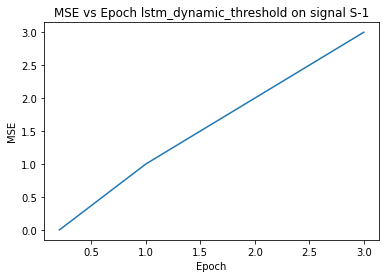

In [299]:
plot_pipeline_mse_per_epoch("S-1", "lstm_dynamic_threshold", 1, 1651096450)

In [ ]:
# """Orion Core module.

# This module defines the Orion Class, which is responsible for the
# main anomaly detection functionality, as well as the interaction
# with the underlying MLBlocks pipelines.
# """
# import json
# import logging
# import os
# import pickle
# from typing import List, Union

# import pandas as pd
# from mlblocks import MLPipeline

# from orion.evaluation import CONTEXTUAL_METRICS as METRICS

# LOGGER = logging.getLogger(__name__)


# class Orion:
#     """Orion Class.

#     The Orion Class provides the main anomaly detection functionalities
#     of Orion and is responsible for the interaction with the underlying
#     MLBlocks pipelines.

#     Args:
#         pipeline (str, dict or MLPipeline):
#             Pipeline to use. It can be passed as:
#                 * An ``str`` with a path to a JSON file.
#                 * An ``str`` with the name of a registered pipeline.
#                 * An ``MLPipeline`` instance.
#                 * A ``dict`` with an ``MLPipeline`` specification.
#         hyperparameters (dict):
#             Additional hyperparameters to set to the Pipeline.
#     """

#     PIPELINES_DIR = tuple(
#         dirname
#         for dirname, _, _ in os.walk(os.path.join(os.path.dirname(__file__), 'pipelines'))
#         if os.path.exists(os.path.join(dirname, os.path.basename(dirname) + '.json'))
#     )
#     PIPELINES = tuple(os.path.basename(pipeline) for pipeline in PIPELINES_DIR)

#     DEFAULT_PIPELINE = 'lstm_dynamic_threshold'

#     def _get_mlpipeline(self):
#         pipeline = self._pipeline
#         if isinstance(pipeline, str) and os.path.isfile(pipeline):
#             with open(pipeline) as json_file:
#                 pipeline = json.load(json_file)

#         mlpipeline = MLPipeline(pipeline)
#         if self._hyperparameters:
#             mlpipeline.set_hyperparameters(self._hyperparameters)

#         return mlpipeline

#     def __init__(self, pipeline: Union[str, dict, MLPipeline] = None,
#                  hyperparameters: dict = None):
#         self._pipeline = pipeline or self.DEFAULT_PIPELINE
#         self._hyperparameters = hyperparameters
#         self._mlpipeline = self._get_mlpipeline()
#         self._fitted = False


#     def __eq__(self, other):
#         return (
#             isinstance(other, self.__class__) and
#             self._pipeline == other._pipeline and
#             self._hyperparameters == other._hyperparameters and
#             self._fitted == other._fitted
#         )

#     def fit(self, data: pd.DataFrame, **kwargs):
#         """Fit the pipeline to the given data.

#         Args:
#             data (DataFrame):
#                 Input data, passed as a ``pandas.DataFrame`` containing
#                 exactly two columns: timestamp and value.
#         """
#         if not self._fitted:
#             self._mlpipeline = self._get_mlpipeline()

#         self._mlpipeline.fit(data, **kwargs)
#         self._fitted = True


#     def _get_outputs_spec(self):
#         outputs_spec = ["default"]
#         try:
#             visualization_outputs = self._mlpipeline.get_output_names('visualization')
#             outputs_spec.append('visualization')
#         except ValueError:
#             visualization_outputs = []

#         return outputs_spec, visualization_outputs

#     @staticmethod
#     def _build_events_df(events):
#         events = pd.DataFrame(list(events), columns=['start', 'end', 'severity'])
#         events['start'] = events['start'].astype('int64')
#         events['end'] = events['end'].astype('int64')

#         return events

#     def _detect(self, method, data, visualization=False, **kwargs):
#         if visualization:
#             outputs_spec, visualization_names = self._get_outputs_spec()
#         else:
#             outputs_spec = 'default'

#         outputs = method(data, output_=outputs_spec, **kwargs)

#         if visualization:
#             if visualization_names:
#                 events = outputs[0]
#                 visualization_outputs = outputs[-len(visualization_names):]
#                 visualization_dict = dict(zip(visualization_names, visualization_outputs))
#             else:
#                 events = outputs
#                 visualization_dict = {}

#             return self._build_events_df(events), visualization_dict

#         return self._build_events_df(outputs)

#     def detect(self, data: pd.DataFrame, visualization: bool = False) -> pd.DataFrame:
#         """Detect anomalies in the given data..

#         If ``visualization=True``, also return the visualization
#         outputs from the MLPipeline object.

#         Args:
#             data (DataFrame):
#                 Input data, passed as a ``pandas.DataFrame`` containing
#                 exactly two columns: timestamp and value.
#             visualization (bool):
#                 If ``True``, also capture the ``visualization`` named
#                 output from the ``MLPipeline`` and return it as a second
#                 output.

#         Returns:
#             DataFrame or tuple:
#                 If visualization is ``False``, it returns the events
#                 DataFrame. If visualization is ``True``, it returns a
#                 tuple containing the events DataFrame followed by the
#                 visualization outputs dict.
#         """
#         return self._detect(self._mlpipeline.predict, data, visualization)


#     def fit_detect(self, data: pd.DataFrame, visualization: bool = False,
#                    **kwargs) -> pd.DataFrame:
#         """Fit the pipeline to the data and then detect anomalies.

#         This method is functionally equivalent to calling ``fit(data)``
#         and later on ``detect(data)`` but with the difference that
#         here the ``MLPipeline`` is called only once, using its ``fit``
#         method, and the output is directly captured without having
#         to execute the whole pipeline again during the ``predict`` phase.

#         If ``visualization=True``, also return the visualization
#         outputs from the MLPipeline object.

#         Args:
#             data (DataFrame):
#                 Input data, passed as a ``pandas.DataFrame`` containing
#                 exactly two columns: timestamp and value.
#             visualization (bool):
#                 If ``True``, also capture the ``visualization`` named
#                 output from the ``MLPipeline`` and return it as a second
#                 output.

#         Returns:
#             DataFrame or tuple:
#                 If visualization is ``False``, it returns the events
#                 DataFrame. If visualization is ``True``, it returns a
#                 tuple containing the events DataFrame followed by the
#                 visualization outputs dict.
#         """
#         if not self._fitted:
#             self._mlpipeline = self._get_mlpipeline()

#         result = self._detect(self._mlpipeline.fit, data, visualization, **kwargs)
#         self._fitted = True

#         return result

#     def save(self, path: str):
#         """Save this object using pickle.

#         Args:
#             path (str):
#                 Path to the file where the serialization of
#                 this object will be stored.
#         """
#         os.makedirs(os.path.dirname(path), exist_ok=True)
#         with open(path, 'wb') as pickle_file:
#             pickle.dump(self, pickle_file)


#     @classmethod
#     def load(cls, path: str):
#         """Load an Orion instance from a pickle file.

#         Args:
#             path (str):
#                 Path to the file where the instance has been
#                 previously serialized.

#         Returns:
#             Orion

#         Raises:
#             ValueError:
#                 If the serialized object is not an Orion instance.
#         """
#         with open(path, 'rb') as pickle_file:
#             orion = pickle.load(pickle_file)
#             if not isinstance(orion, cls):
#                 raise ValueError('Serialized object is not an Orion instance')

#             return orion


#     def evaluate(self, data: pd.DataFrame, ground_truth: pd.DataFrame, fit: bool = False,
#                  train_data: pd.DataFrame = None, metrics: List[str] = METRICS) -> pd.Series:
#         """Evaluate the performance against ground truth anomalies.

#         Args:
#             data (DataFrame):
#                 Input data, passed as a ``pandas.DataFrame`` containing
#                 exactly two columns: timestamp and value.
#             ground_truth (DataFrame):
#                 Ground truth anomalies passed as a ``pandas.DataFrame``
#                 containing two columns: start and stop.
#             fit (bool):
#                 Whether to fit the pipeline before evaluating it.
#                 Defaults to ``False``.
#             train_data (DataFrame):
#                 Training data, passed as a ``pandas.DataFrame`` containing
#                 exactly two columns: timestamp and value.
#                 If not given, the pipeline is fitted on ``data``.
#             metrics (list):
#                 List of metrics to used passed as a list of strings.
#                 If not given, it defaults to all the Orion metrics.

#         Returns:
#             Series:
#                 ``pandas.Series`` containing one element for each
#                 metric applied, with the metric name as index.
#         """
#         if not fit:
#             method = self._mlpipeline.predict
#         else:
#             if not self._fitted:
#                 mlpipeline = self._get_mlpipeline()

#             if train_data is not None:
#                 # Fit first and then predict
#                 mlpipeline.fit(train_data)
#                 method = mlpipeline.predict
#             else:
#                 # Fit and predict at once
#                 method = mlpipeline.fit

#         events = self._detect(method, data)

#         scores = {
#             metric: METRICS[metric](ground_truth, events, data=data)
#             for metric in metrics
#         }

#         return pd.Series(scores)
